Importing dataset

In [ ]:
import pandas as pd
df = pd.read_csv('song_data.xls.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


Preprocessing:


*   Drop duplicates
*   Scale values

In [ ]:
df.shape
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
df.shape

3909


(14926, 15)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['song_duration_ms']] = scaler.fit_transform(df[['song_duration_ms']])
df[['song_popularity']] = scaler.fit_transform(df[['song_popularity']])
df[['loudness']] = scaler.fit_transform(df[['loudness']])
df[['tempo']] = scaler.fit_transform(df[['tempo']])
df[['key']] = scaler.fit_transform(df[['key']])
df[['time_signature']] = scaler.fit_transform(df[['time_signature']])

In [ ]:
df.head(5)

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,0.73,0.140059,0.005520,0.496,0.682,0.000029,0.727273,0.0589,0.859242,1,0.0294,0.689425,0.8,0.474
1,In The End,0.66,0.114658,0.010300,0.542,0.853,0.000000,0.272727,0.1080,0.801948,0,0.0498,0.434371,0.8,0.370
2,Seven Nation Army,0.76,0.122938,0.008170,0.737,0.463,0.447000,0.000000,0.2550,0.766734,1,0.0792,0.511233,0.8,0.324
3,By The Way,0.74,0.114658,0.026400,0.451,0.970,0.003550,0.000000,0.1020,0.838352,1,0.1070,0.505303,0.8,0.198
4,How You Remind Me,0.56,0.118514,0.000954,0.447,0.766,0.000000,0.909091,0.1130,0.835204,1,0.0313,0.709856,0.8,0.574


In [ ]:
df_new = df.drop(columns=['song_name'])

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
X = df_new

Train kMeans clustering model and add a new column assigning a cluster to each row

In [ ]:
k = 4
km = KMeans(n_clusters=k, random_state=42)
km.fit(X)
labels = km.labels_
centroids = km.cluster_centers_

Identify the genres based on the centroids

In [ ]:
from scipy.spatial.distance import cdist
df_genre = pd.read_csv('genre_features.csv')
feature_columns = df_genre.columns[1:]
genre_features = df_genre[feature_columns].values
centroids = np.array(centroids)
distances = cdist(centroids, genre_features, metric="euclidean")
assigned_genres = set()
selected_genres = []
for i, centroid_dist in enumerate(distances):
    sorted_indices = np.argsort(centroid_dist)  # Sort by closest match
    for index in sorted_indices:
        genre = df_genre.iloc[index, 0]  # Get genre name
        if genre not in assigned_genres:  # Ensure uniqueness
            assigned_genres.add(genre)
            selected_genres.append((f"Centroid {i+1}", genre))
            break
genres = []
for centroid, g in selected_genres:
    print(f"{centroid}: {g}")
    genres.append(f"{g}")

Centroid 1: Ambient
Centroid 2: Hip-Hop
Centroid 3: Pop
Centroid 4: Funk


Assigning clusters to each data row

In [ ]:
df_new["Cluster"] = km.predict(df_new.values)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Count songs belonging to each genre

In [ ]:
cluster_counts_list = [df_new["Cluster"].value_counts().get(i, 0) for i in range(df_new['Cluster'].nunique())]
cluster_counts = df_new["Cluster"].value_counts().sort_index().tolist()
df_cluster_summary = pd.DataFrame({
    "Genre": genres,
    "Song Count": cluster_counts_list
})

print(df_cluster_summary)

     Genre  Song Count
0  Ambient        2042
1  Hip-Hop        3962
2      Pop        5363
3     Funk        3559


Visualize the centroids based on a heatmap using various genres

(as there are more than 2 input features, creating a 2D graph is not feasible)

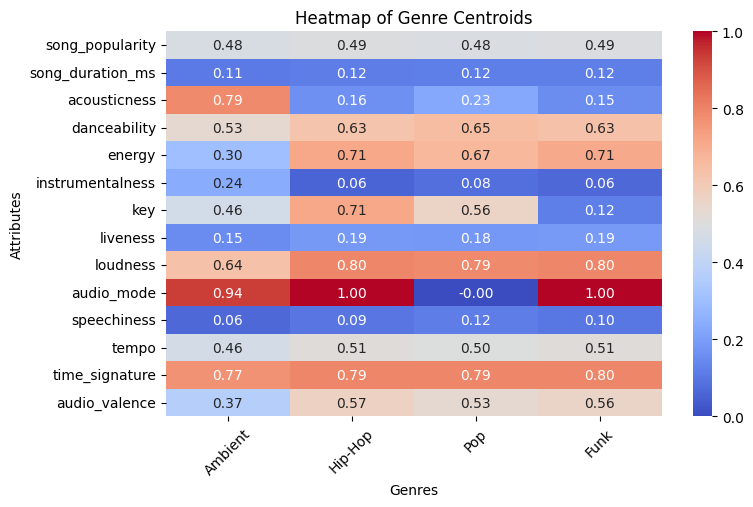

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_counts = pd.Series(labels).value_counts().sort_index().tolist()
genres_with_counts = [f"{genre} ({count})" for genre, count in zip(genres, cluster_counts)]
df_genre_centroids = pd.DataFrame(centroids, columns=df_new.columns[:-1])
df_genre_centroids.insert(0, "Genre", genres)
df_transposed = df_genre_centroids.set_index("Genre").T

plt.figure(figsize=(8, 5))
sns.heatmap(df_transposed, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Genre Centroids")
plt.xlabel("Genres")
plt.ylabel("Attributes")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# print("Inertia:", km.inertia_)

Silhouette score method for finding number of clusters needed

In [ ]:
# from sklearn.metrics import silhouette_score

# best_k = 2
# best_score = -1

# for k in range(2, 15):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(X_original)
#     score = silhouette_score(X_original, labels)

#     if score > best_score:
#         best_score = score
#         best_k = k

# print(f"Optimal number of clusters: {best_k}")

Elbow method for finding number of clusters needed

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# inertia = []
# K_range = range(2, 15)  # Test different cluster numbers

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_original)
#     inertia.append(kmeans.inertia_)

# # Plot the elbow curve
# plt.plot(K_range, inertia, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal Clusters')
# plt.show()

In [ ]:
# print(pd.DataFrame(centroids, columns=df_new.columns))

Identify the songs closest to the centroids

In [ ]:
# from scipy.spatial.distance import cdist
# feature_columns = df.columns.difference(['song_name'])
# X_original = df[feature_columns].values
# distances = cdist(centroids, X_original, metric='euclidean')
# closest_indices = []
# used_indices = set()

# for i in range(len(centroids)):
#     sorted_indices = np.argsort(distances[i])
#     for idx in sorted_indices:
#         if idx not in used_indices:
#             closest_indices.append(idx)
#             used_indices.add(idx)
#             break

# df_matched = df.iloc[closest_indices][['song_name']]
# df_matched['Cluster'] = range(len(centroids))
# print('Centroids')
# print(df_matched)

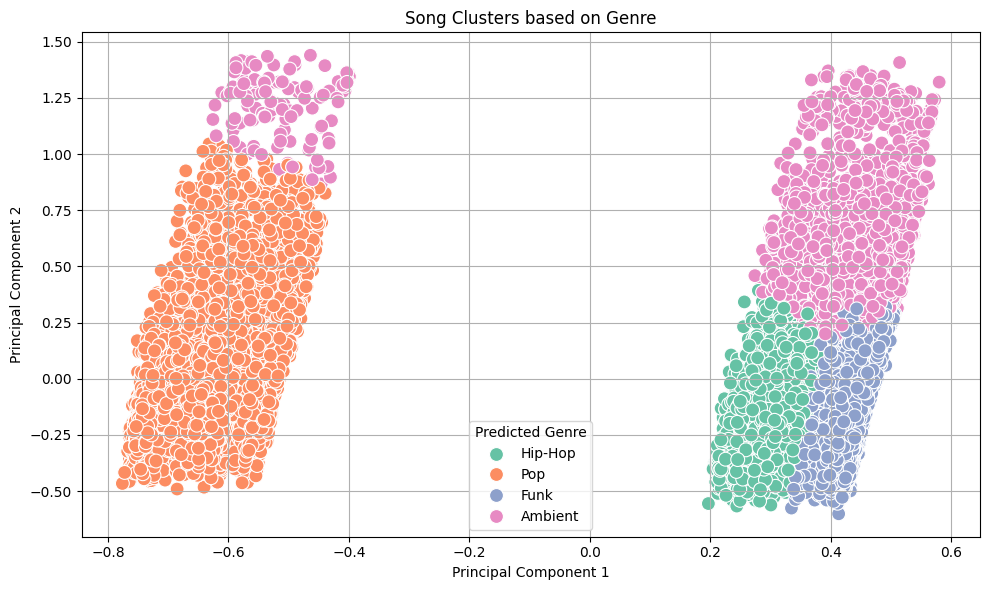

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Apply PCA
X_pca = df_new.drop(columns=["Cluster"])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_pca)

# DataFrame for PCA results + cluster + genre label
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["Cluster"] = df_new["Cluster"]
pca_df["Genre_Label"] = [genres[cluster] for cluster in df_new["Cluster"]]


plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Genre_Label", palette="Set2", s=100)
plt.title("Song Clusters based on Genre")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Predicted Genre")
plt.grid(True)
plt.tight_layout()
plt.show()
